# Sensitivity Profiles With Achilles Data

Author: Jon Katz  
Date:   2021-10-19  
Description: Example import data from the depmap portal

Steps:

    1. Download Achilles scores data from depmap portal 
    2. Create coloring function
    3. Select genes to visualize
    4. Plot a panel of barplots

From the Broad Institute file description: ATARiS gene level scores for 33 cell lines passing quality control (p=0.05).  Pre-processed using z-score normalization, 120K sgRNA GeCKOv2 CRISPR-Cas9 library, next-generation sequencing deconvolution.

## 1. Download Achilles Scores Data

In [1]:
library(httr)
library(jsonlite)
library(readr)
library(repr)



## Download Achilles 3.3.8
gsfile <- tempfile()
x <- httr::GET('https://depmap.org/portal/download/api/download',
  query = list(
    file_name='7/Achilles_v3.3.8.Gs.gct',
    bucket = 'depmap-external-downloads'),
    httr::write_disk(gsfile, overwrite = TRUE)
)
gsdat <- read.table(gsfile, skip=2, header=TRUE)

## 2. Create Coloring Function

In [2]:
# Identify what primary sites are in the data
cn <- colnames(gsdat)[3:ncol(gsdat)]
m <- regexpr("_.*", cn)
mx <- regmatches(cn, m)
colorcats <- gsub("^_", "", unique(mx))
recats <- paste0(unique(mx), collapse="|")
# make a color pallette
lifeaquatic <- setNames(hcl.colors(length(colorcats), "Zissou 1"), nm=colorcats)
# fn to apply the pallette to sites 
makecols <- function(primarysite, pallette, legend=FALSE) {
  if(legend) return(unname(pallette[primarysite]))
  m1 <- regexpr("_.*", primarysite)
  mx1 <- gsub("^_", "", regmatches(primarysite, m1))
  unname(pallette[mx1])
}

## 3. Select Genes to Visualize

In [3]:
genelist <- c("AKT1", "BRCA1", "IKZF2", "MTOR", "TP53", "ZWINT") 
ylim <- range(gsdat[gsdat[,'Description'] %in% genelist, 3:ncol(gsdat)])

## 4. Plot a Panel of Barplots
Sensitivity score per cell line, colored by primary site.

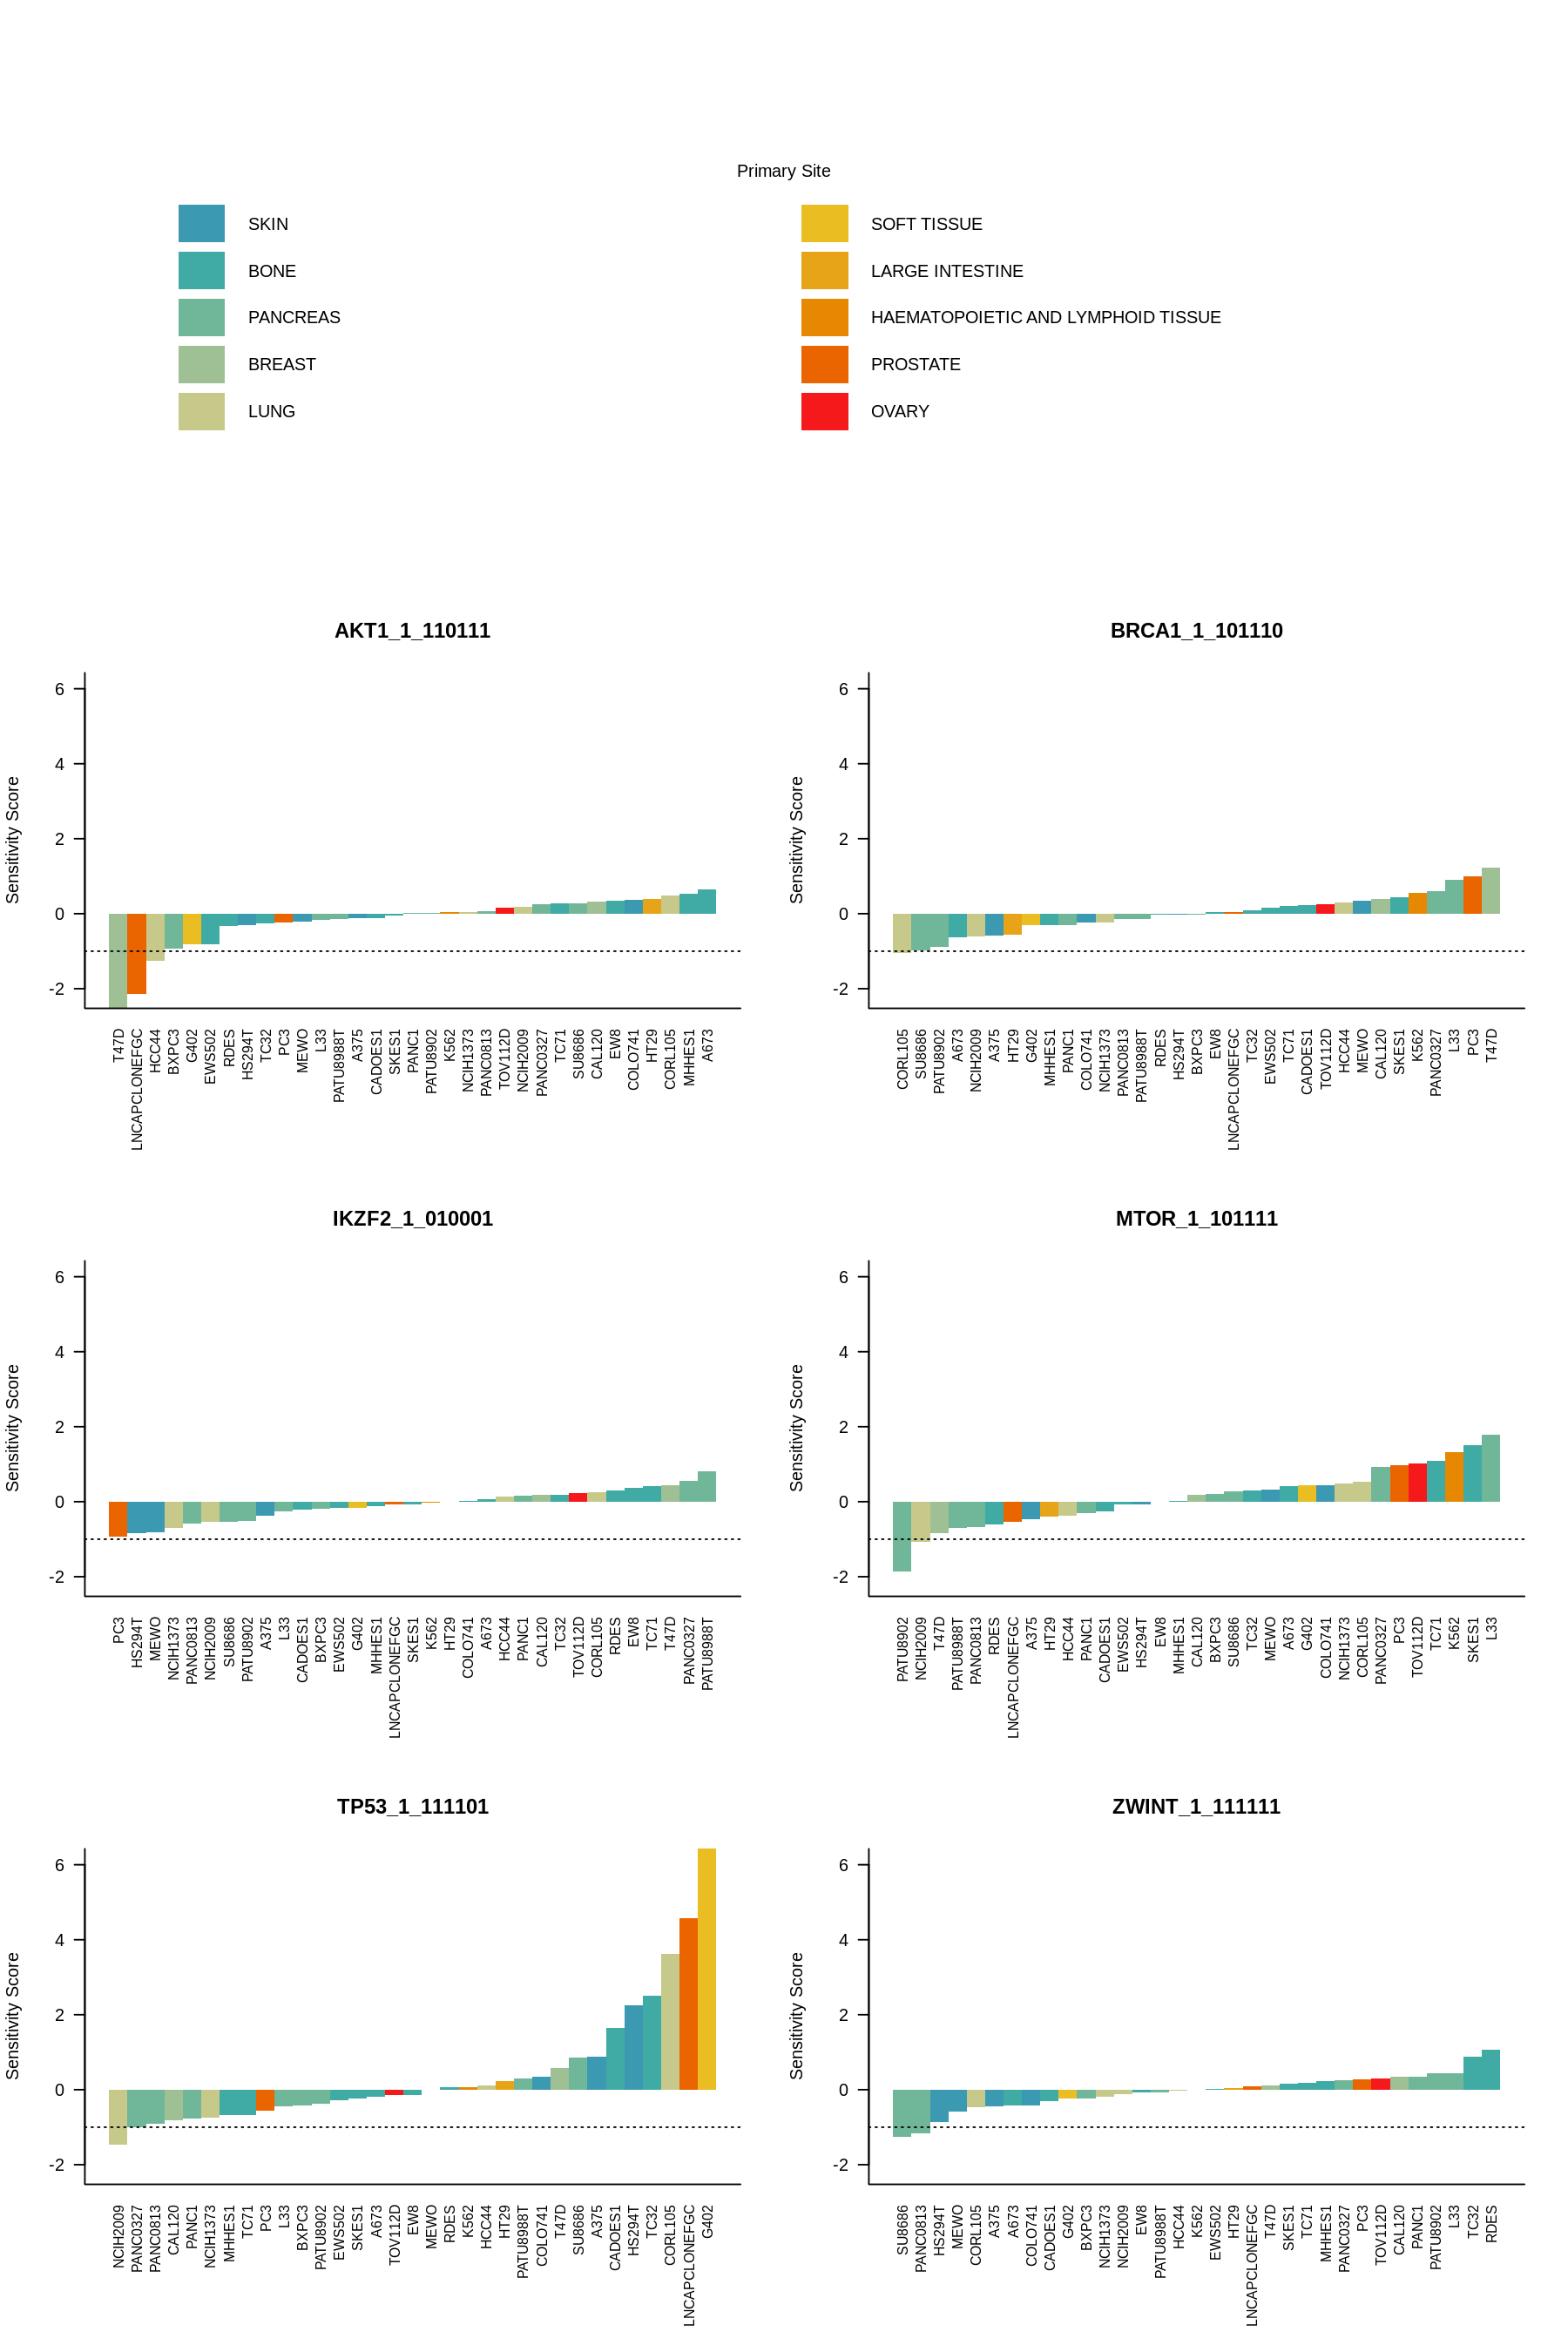

In [30]:
# Change plot size
options(repr.plot.width=10, repr.plot.height=15, repr.plot.res=180)
layout(matrix(c(1,1,2:7), ncol=2, byrow=TRUE))
# allow bigger boxes in legend
source("http://www.math.mcmaster.ca/bolker/R/misc/legendx.R")

par(mar=c(0,0,0,0)+0.1)
plot.new()
legend(
    'center', 
    legend=gsub("_", " ", colorcats), 
    fill=makecols(colorcats, lifeaquatic, TRUE), 
    border=NA, 
    bty='n', 
    ncol=2, 
    box.cex=c(2,0.8), 
    title="Primary Site"
)
# Panel plot
for(i in genelist) {
  par(mar=c(8,4,4,2)+0.1)
  tmpdat <- t(gsdat[which(gsdat[,'Description'] == i)[1], 3:ncol(gsdat)])
  main <- gsdat[which(gsdat[,'Description'] == i)[1], 'Name']
  tmpdat <- tmpdat[order(tmpdat[,1]),,drop=FALSE]
  barplot(
      tmpdat, 
      space=c(0,0), 
      names.arg=gsub(recats, "", rownames(tmpdat)), 
      col=makecols(rownames(tmpdat), lifeaquatic), 
      beside=TRUE, 
      border=NA, 
      ylim=ylim, 
      las=2, 
      cex.names=0.8, 
      main=main, 
      ylab="Sensitivity Score"
  )
  abline(h=-1, lty=3)
  box(bty="l")
}